<a href="https://colab.research.google.com/github/Luis-Eduardo-P-Ch/Programacion-para-el-Analisis-de-datos/blob/main/An%C3%A1lisis%20Preliminar%20de%20Taxis%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install geopandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shapely.wkt
import folium
import geopandas as gpd

#Carga del dataset

In [ ]:
df = pd.DataFrame()

for i in range(1,13):
    
    df_aux = pd.read_parquet(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2016-{i:02d}.parquet')
    df_aux = df_aux.sample(frac=0.01, random_state=434)
    df = pd.concat([df, df_aux]).reset_index(drop=True)

#Limpieza de datos

In [ ]:
#Eliminamos las columnas que no usaremos
df = df.drop(labels=["VendorID","store_and_fwd_flag","airport_fee","congestion_surcharge"],axis=1)

#Eliminamos los tipo de pago != 1, ya que solo nos quedamos con los pagos en tarjeta de credito
df = df[df["payment_type"]==1]

#Eliminamos los Rate Code ID != 99 ya que no se encuentran especificados en la documentacion del dataset
df = df[df["RatecodeID"]!=99]

#Eliminamos los viajes con cero pasajeros
df = df[df["passenger_count"]!=0]

In [ ]:
#Tomamos los percentiles 99 de las columnas numericas que nos interesan para identificar los outliers (dejamos un 20% extra)
top_tip_amount= np.percentile(df["tip_amount"], 99) * 1.2
top_distance =  np.percentile(df["trip_distance"],99) * 1.2

df["trip_time_secs"] = ((df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"])).astype('timedelta64[s]')
top_time = np.percentile(df['trip_time_secs'],99) * 1.2
top_amount = np.percentile(df['total_amount'],99) *1.2

#Filtrmos los outliers 
df = df[(df['tip_amount'] < top_tip_amount ) & (df['tip_amount'] >= 0) ]
df = df[(df['trip_distance'] < top_distance) & (df['trip_distance'] > 0) ]
df = df[(df['trip_time_secs'] > 0) & (df['trip_time_secs'] < top_time) ]
df = df[(df['total_amount'] < top_amount) & (df['total_amount'] > 0) ]


#Creacion de columnas

In [ ]:
df["tip_by_mile"] = df["tip_amount"]/df["trip_distance"]
df["tip_by_sec"] = df["tip_amount"]/df['trip_time_secs']

#Hay un valor máximo de "inf" lo cual no puede estar bien y molesta para los plots. Hay que chequearlo
df["tip_by_passenger"] = df["tip_amount"]/df["passenger_count"]

df["month"] = (df.tpep_pickup_datetime.dt.month).astype("category")
df["day_of_week"] = (df.tpep_pickup_datetime.dt.day_of_week).astype("category")
df["trip_time_mins"] = df["trip_time_secs"]/60

df["tip_by_min"] = df["tip_amount"]/df['trip_time_mins']
df['pick_hour'] = df.tpep_pickup_datetime.dt.hour
df['pick_day_name']  = df.tpep_pickup_datetime.dt.day_name()
#Renaming de las locations y las pickup y dropoff time para que sea más claro

df.rename(columns= {"PULocationID":"pick_location" , "DOLocationID":"drop_location", "tpep_pickup_datetime":"pick_datetime", "tpep_dropoff_datetime":"drop_datetime"}, inplace = True)


#Datos de zonas

In [ ]:
locations_data = pd.read_csv("https://data.cityofnewyork.us/api/views/755u-8jsi/rows.csv?accessType=DOWNLOAD")


In [ ]:

def get_longitude(row):
    shape = shapely.wkt.loads(row.the_geom)
    return shape.centroid.coords[0][0]

def get_latitude(row):
    shape = shapely.wkt.loads(row.the_geom)
    return shape.centroid.coords[0][1]

In [ ]:
locations_data['latitude'] = locations_data.apply(get_latitude, axis=1)
locations_data['longitude'] = locations_data.apply(get_longitude, axis=1)

In [ ]:


ny_map = folium.Map(location=[locations_data.loc[0].latitude, locations_data.loc[0].longitude ], tiles="OpenStreetMap", zoom_start=12)

for i in range(0,len(locations_data)):
    folium.Marker(
        location=[locations_data.iloc[i]['latitude'], locations_data.iloc[i]['longitude']],
        popup=locations_data.iloc[i]['LocationID'],
    ).add_to(ny_map)

In [ ]:

df = df.merge(locations_data[["zone", "LocationID","borough", "latitude", "longitude"]], how="left", left_on="pick_location", right_on="LocationID",suffixes=[None,"_pick"]).drop("LocationID",axis=1)
df = df.merge(locations_data[["zone", "LocationID","borough", "latitude", "longitude"]], how="left", left_on="drop_location", right_on="LocationID",suffixes=[None,"_drop"]).drop("LocationID",axis=1)

df.rename(columns= {"borough":"borough_pick" , "zone":"zone_pick", "latitude":"latitude_pickup", "longitude":"longitude_pickup"}, inplace = True)
df.rename(columns= {"borough":"borough_drop" , "zone":"zone_drop", "latitude":"latitude_drop", "longitude":"longitude_drop"}, inplace = True)


#Graficos

In [ ]:
df.columns

Index(['pick_datetime', 'drop_datetime', 'passenger_count', 'trip_distance',
       'RatecodeID', 'pick_location', 'drop_location', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'trip_time_secs',
       'tip_by_mile', 'tip_by_sec', 'tip_by_passenger', 'month', 'day_of_week',
       'trip_time_mins', 'tip_by_min', 'pick_hour', 'pick_day_name',
       'zone_pick', 'borough_pick', 'latitude_pickup', 'longitude_pickup',
       'zone_drop', 'borough_drop', 'latitude_drop', 'longitude_drop'],
      dtype='object')

In [ ]:
df_mean_tip_zone_pick = pd.DataFrame(df.groupby(['borough_pick'])['tip_by_min'].mean().reset_index())
df_mean_tip_zone_pick.sort_values(by = 'tip_by_min', ascending = False, inplace = True)

In [ ]:
df_mean_tip_zone_drop = pd.DataFrame(df.groupby(['borough_drop'])['tip_by_min'].mean().reset_index())
df_mean_tip_zone_drop.sort_values(by = 'tip_by_min', ascending = False, inplace = True)

In [ ]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

<Axes: xlabel='borough_drop', ylabel='tip_by_min'>

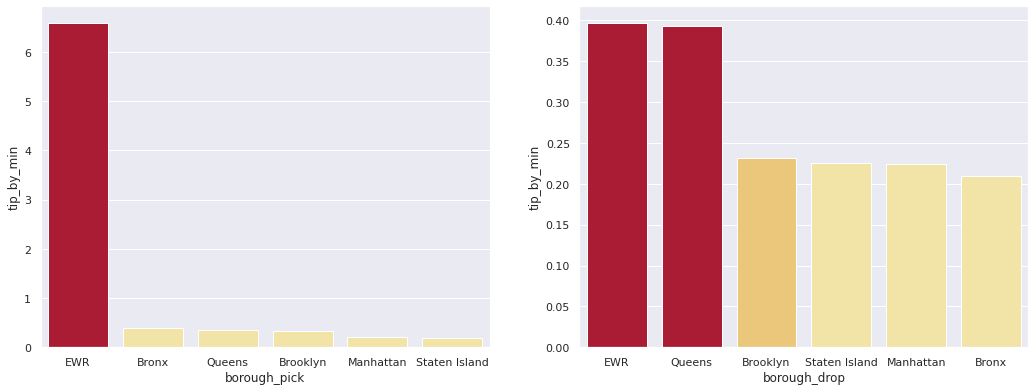

In [ ]:
sns.set(rc={'figure.figsize':(17.7,6.27)})
fig, axes = plt.subplots(1, 2)
sns.set_palette("YlOrRd")


sns.barplot(data = df_mean_tip_zone_pick, x = 'borough_pick', y = 'tip_by_min', ax=axes[0] , palette=colors_from_values(df_mean_tip_zone_pick.tip_by_min, "YlOrRd") )
sns.barplot(data = df_mean_tip_zone_drop, x = 'borough_drop', y = 'tip_by_min' , ax=axes[1], palette=colors_from_values(df_mean_tip_zone_drop.tip_by_min, "YlOrRd"))

In [ ]:
df_mean_tip_hour_pick = pd.DataFrame(df.groupby(['pick_hour'])['tip_by_min'].mean().reset_index())


<Axes: xlabel='pick_hour', ylabel='tip_by_min'>

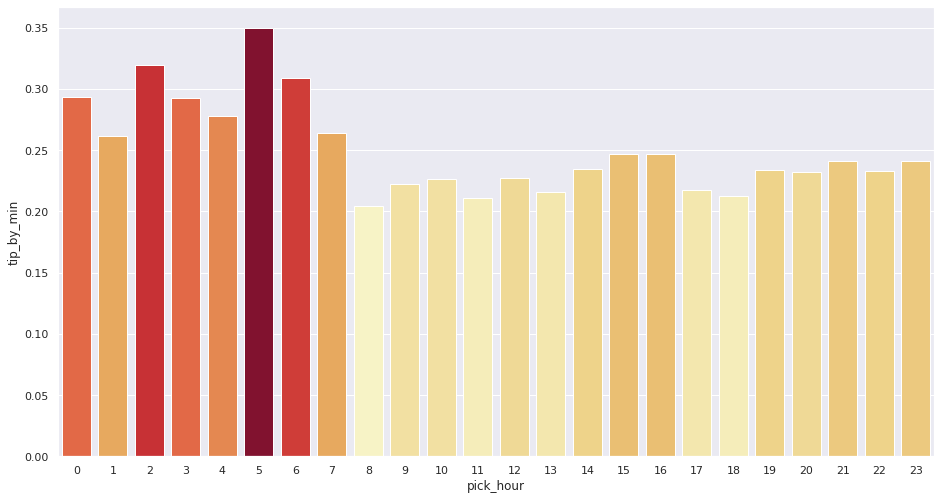

In [ ]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.barplot(data=df_mean_tip_hour_pick, x="pick_hour", y="tip_by_min", palette=colors_from_values(df_mean_tip_hour_pick.tip_by_min, "YlOrRd"))

In [ ]:
df_mean_tip_day_pick = pd.DataFrame(df.groupby(['pick_day_name', 'day_of_week'])['tip_by_min'].mean().reset_index())

df_mean_tip_day_pick.sort_values(by = 'day_of_week', inplace = True)
df_mean_tip_day_pick.dropna(inplace = True)

<Axes: xlabel='pick_day_name', ylabel='tip_by_min'>

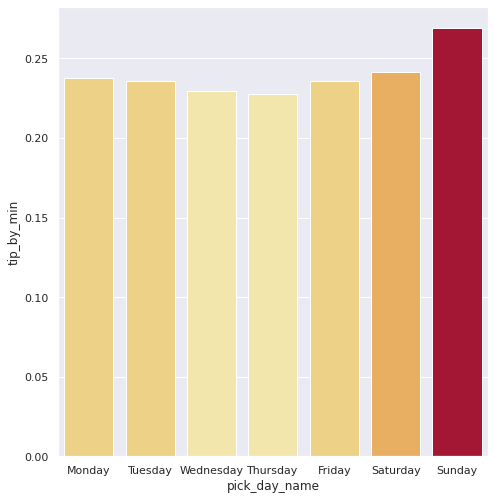

In [ ]:
sns.set(rc={'figure.figsize':(7.7,8.27)})
sns.barplot(data=df_mean_tip_day_pick, x="pick_day_name", y="tip_by_min", palette=colors_from_values(df_mean_tip_day_pick.tip_by_min, "YlOrRd"))

In [ ]:
heatmap = df.groupby(['pick_day_name', 'pick_hour'])['tip_by_min'].mean().reset_index()
heatmap = heatmap.pivot(columns = 'pick_hour', index = 'pick_day_name', values = 'tip_by_min')

<Axes: xlabel='pick_hour', ylabel='pick_day_name'>

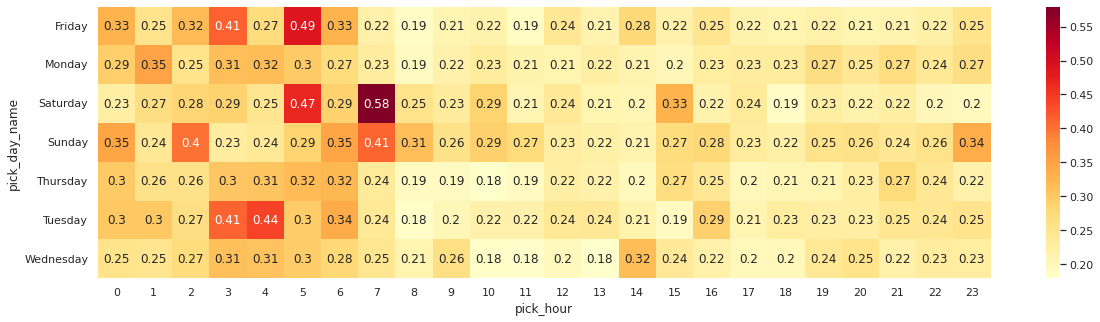

In [ ]:
fig, axs = plt.subplots(1,1, figsize = (20,5))
sns.heatmap(heatmap, annot = True, ax = axs, cmap="YlOrRd")

In [ ]:
heatmap_2 = df.groupby(['pick_day_name', 'borough_pick'])['tip_by_min'].mean().reset_index()
heatmap_2 = heatmap_2[heatmap_2['borough_pick'] != 'EWR']
heatmap_2 = heatmap_2.pivot(columns = 'borough_pick', index = 'pick_day_name', values = 'tip_by_min')

heatmap_3 = df.groupby(['pick_day_name', 'borough_pick'])['pick_datetime'].count().reset_index()
heatmap_3 = heatmap_3[heatmap_3['borough_pick'] != 'EWR']
heatmap_3.rename(columns= {"pick_datetime":"trip_count"}, inplace = True)
heatmap_3 = heatmap_3.pivot(columns = 'borough_pick', index = 'pick_day_name', values = 'trip_count')


<Axes: xlabel='borough_pick', ylabel='pick_day_name'>

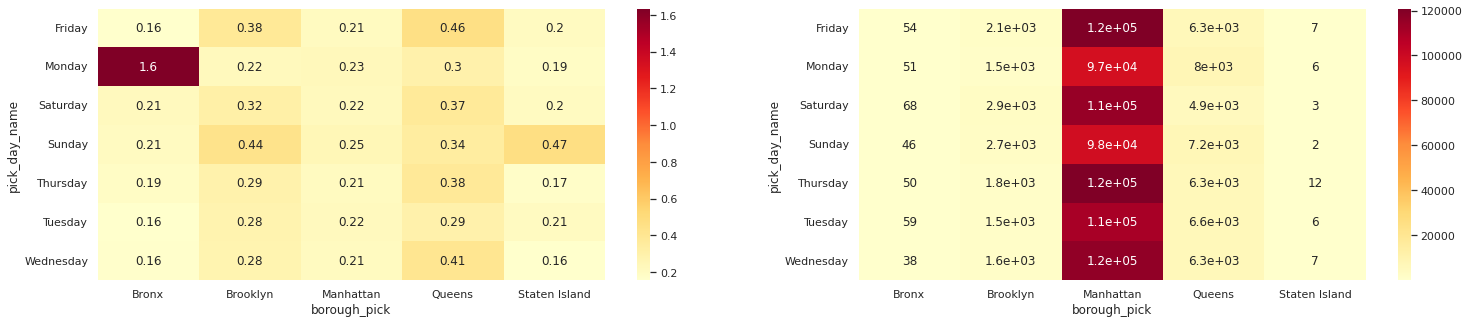

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (25,5))
sns.heatmap(heatmap_2, annot = True, ax = axs[0], cmap="YlOrRd")
sns.heatmap(heatmap_3, annot = True, ax = axs[1], cmap="YlOrRd")

#Mapa

In [ ]:
zones = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile')

In [ ]:
nyc_map = folium.Map(location=[40.7128, -74.0060], tiles="OpenStreetMap",zoom_start=10)

In [ ]:
df_zones = df.groupby(['zone_pick', 'latitude_pickup', 'longitude_pickup'])['tip_by_min'].mean().reset_index()

In [ ]:
merged_map = pd.merge(zones, df_zones, left_on = 'zone', right_on = 'zone_pick')

In [ ]:
folium.Choropleth(
    geo_data=merged_map,
    name='choropleth',
    data=merged_map,
    columns=['zone_pick', 'tip_by_min'],
    key_on='feature.properties.zone',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.5,
    legend_name='Tip by Minute'
).add_to(nyc_map)

In [ ]:
folium.LayerControl().add_to(nyc_map)

In [ ]:
nyc_map

In [ ]:
df_mean_tip_zone_pick = pd.DataFrame(df.groupby(['zone_pick', 'borough_pick'])['tip_by_min'].mean().reset_index())
df_mean_tip_zone_pick_top_10 = df_mean_tip_zone_pick.sort_values(by = 'tip_by_min', ascending = False)
df_mean_tip_zone_pick_low_10 = df_mean_tip_zone_pick.sort_values(by = 'tip_by_min')

Text(0.5, 1.0, 'Tip by minute Low 10')

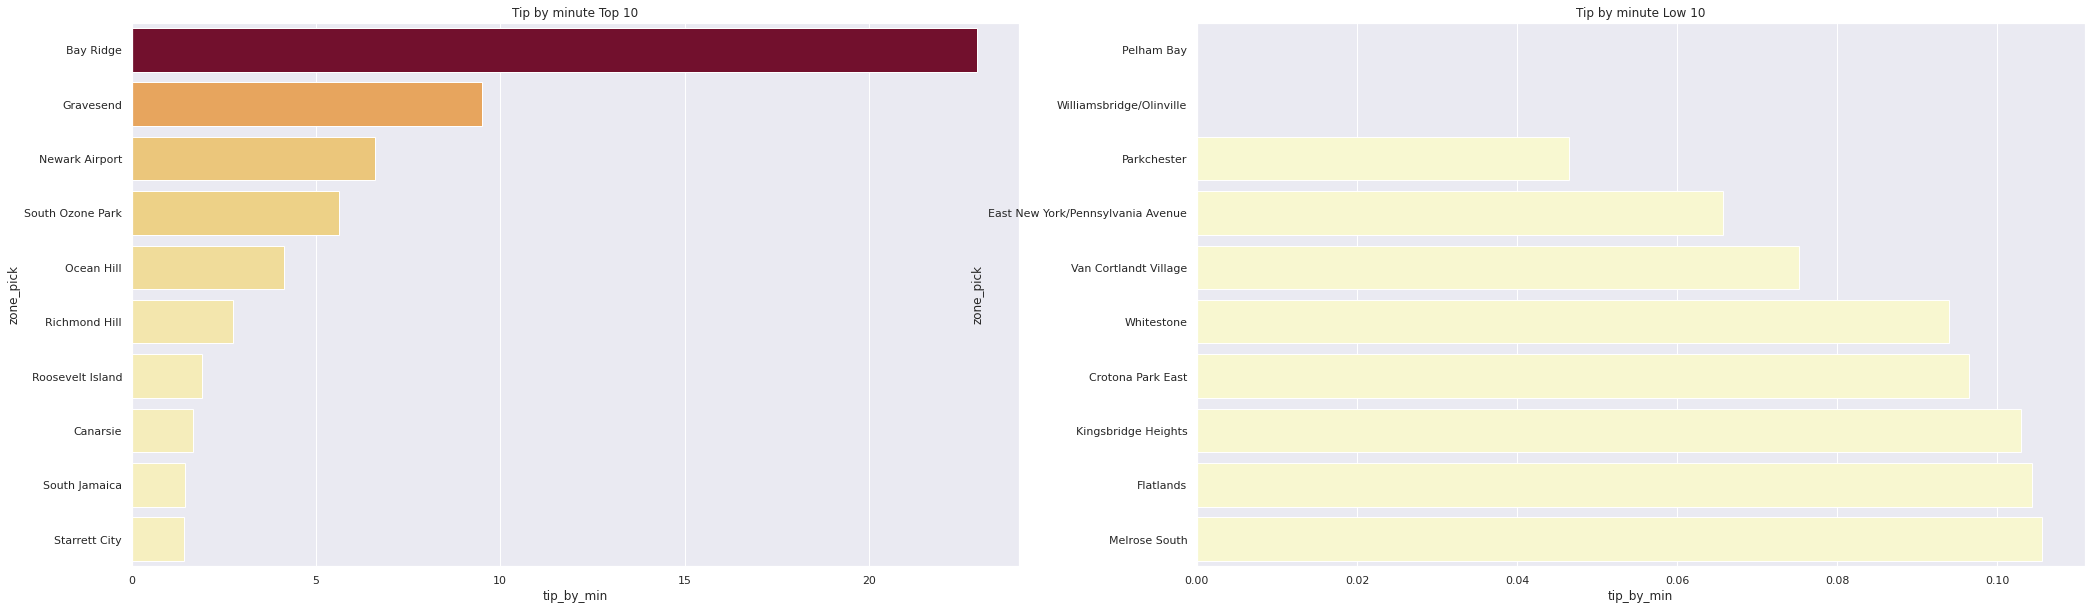

In [ ]:
sns.set(rc={'figure.figsize':(35,10)})
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(data=df_mean_tip_zone_pick_top_10.head(10), y="zone_pick", x="tip_by_min",ax=ax1 , orient = 'h', palette=colors_from_values(df_mean_tip_zone_pick_top_10.tip_by_min, "YlOrRd"))

sns.barplot(data=df_mean_tip_zone_pick_low_10.head(10), y="zone_pick", x="tip_by_min", ax=ax2 , orient = 'h', palette=colors_from_values(df_mean_tip_zone_pick_low_10.tip_by_min, "YlOrRd"))
ax1.set_title('Tip by minute Top 10')
ax2.set_title('Tip by minute Low 10')


In [ ]:
df_count_trip_zone_pick = pd.DataFrame(df.groupby(['zone_pick', 'borough_pick'])['pick_datetime'].count().reset_index())
df_count_trip_zone_pick.rename(columns= {"pick_datetime":"trip_count"}, inplace = True)


In [ ]:
df_count_trip_zone_pick_top_10 = df_count_trip_zone_pick.sort_values(by = 'trip_count', ascending = False)
df_count_trip_zone_pick_low_10 = df_count_trip_zone_pick.sort_values(by = 'trip_count')

Text(0.5, 1.0, 'Trip count Low 10')

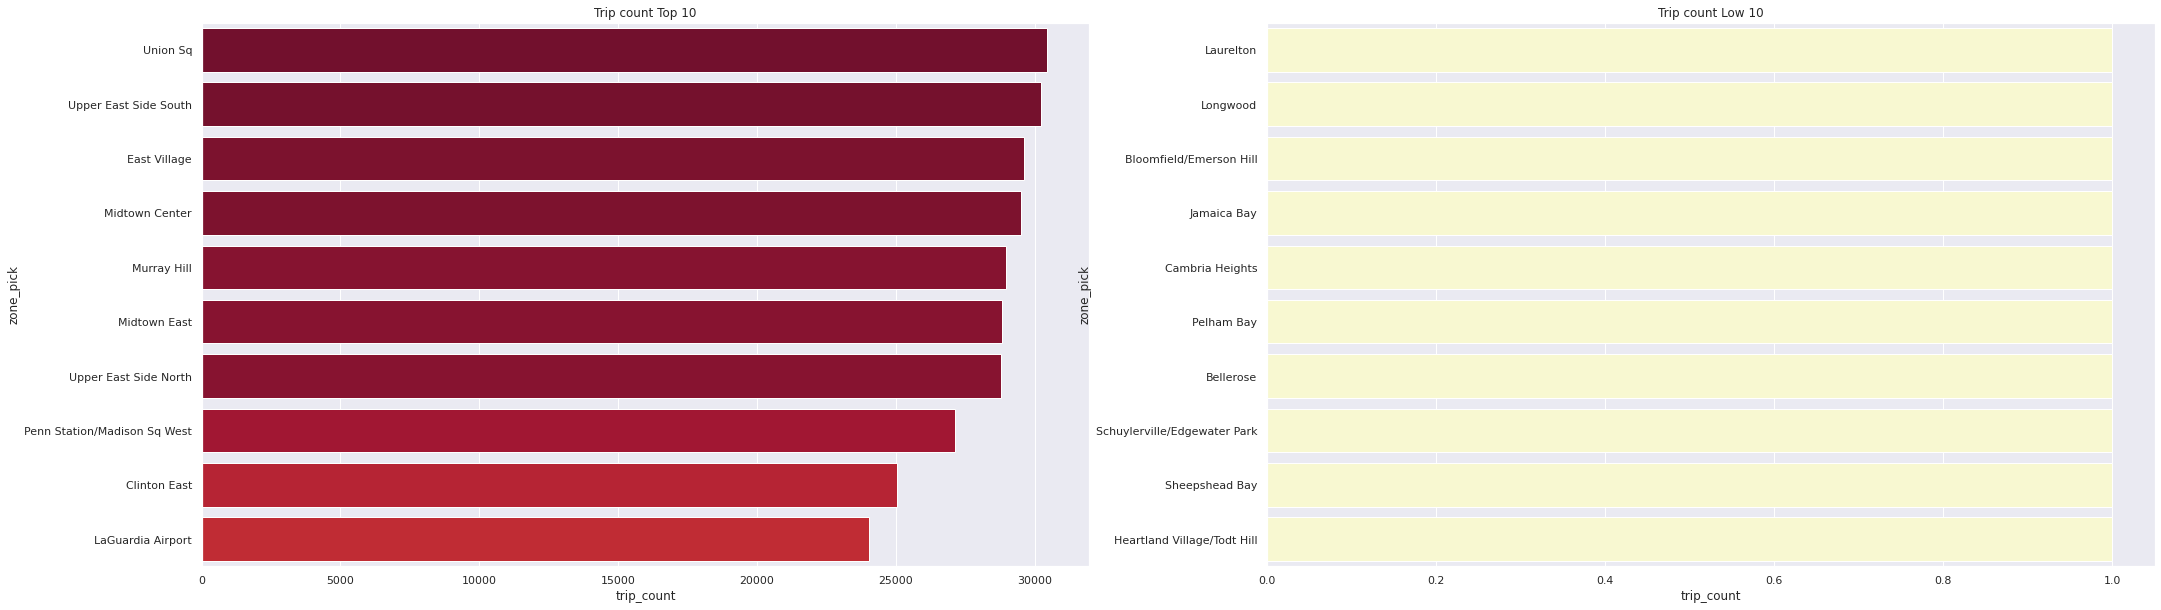

In [ ]:
sns.set(rc={'figure.figsize':(35,10)})
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(data=df_count_trip_zone_pick_top_10.head(10), y="zone_pick", x="trip_count",ax=ax1 , orient = 'h', palette=colors_from_values(df_count_trip_zone_pick_top_10.trip_count, "YlOrRd"))
sns.barplot(data=df_count_trip_zone_pick_low_10.head(10), y="zone_pick", x="trip_count", ax=ax2 , orient = 'h', palette=colors_from_values(df_count_trip_zone_pick_low_10.trip_count, "YlOrRd"))
ax1.set_title('Trip count Top 10')
ax2.set_title('Trip count Low 10')

In [ ]:
#trip_time_mins
df_sum_time_zone_pick = pd.DataFrame(df.groupby(['zone_pick', 'borough_pick'])['trip_time_mins'].sum().reset_index())
df_sum_time_zone_pick.sort_values(by = 'trip_time_mins', ascending = False)



,zone_pick,borough_pick,trip_time_mins
112,LaGuardia Airport,Queens,765753.550000
102,JFK Airport,Queens,590613.583333
134,Midtown Center,Manhattan,418559.416667
199,Union Sq,Manhattan,404954.866667
135,Midtown East,Manhattan,399696.166667
...,...,...,...
105,Jamaica Bay,Queens,7.016667
84,Gravesend,Brooklyn,6.633333
155,Pelham Bay,Bronx,6.366667
56,East Flushing,Queens,6.016667


<Axes: xlabel='tip_by_min', ylabel='passenger_count'>

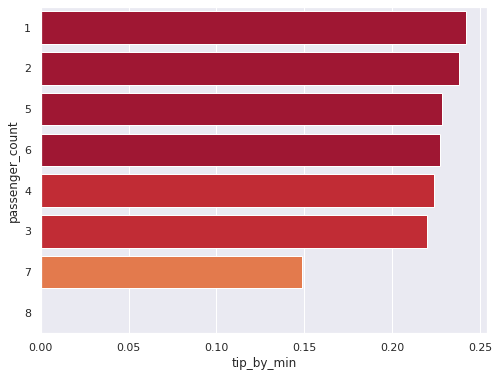

In [ ]:
df_mean_tip_passenger_count = pd.DataFrame(df.groupby(['passenger_count'])['tip_by_min'].mean().reset_index())
df_mean_tip_passenger_count.sort_values(by = 'tip_by_min', ascending = False, inplace = True)
df_mean_tip_passenger_count['passenger_count'] = df_mean_tip_passenger_count['passenger_count'].astype(str)
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data=df_mean_tip_passenger_count, y="passenger_count", x="tip_by_min", orient = 'h', palette=colors_from_values(df_mean_tip_passenger_count.tip_by_min, "YlOrRd"))


In [ ]:
df.columns

Index(['pick_datetime', 'drop_datetime', 'passenger_count', 'trip_distance',
       'RatecodeID', 'pick_location', 'drop_location', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'trip_time_secs',
       'tip_by_mile', 'tip_by_sec', 'tip_by_passenger', 'month', 'day_of_week',
       'trip_time_mins', 'tip_by_min', 'pick_hour', 'pick_day_name',
       'zone_pick', 'borough_pick', 'latitude_pickup', 'longitude_pickup',
       'zone_drop', 'borough_drop', 'latitude_drop', 'longitude_drop'],
      dtype='object')

In [ ]:
df_2 = df[['total_amount', 'tip_amount']].sample(frac = 0.1)
df_2 = df_2[df_2['tip_amount'] != 0]


<Axes: xlabel='total_amount', ylabel='tip_amount'>

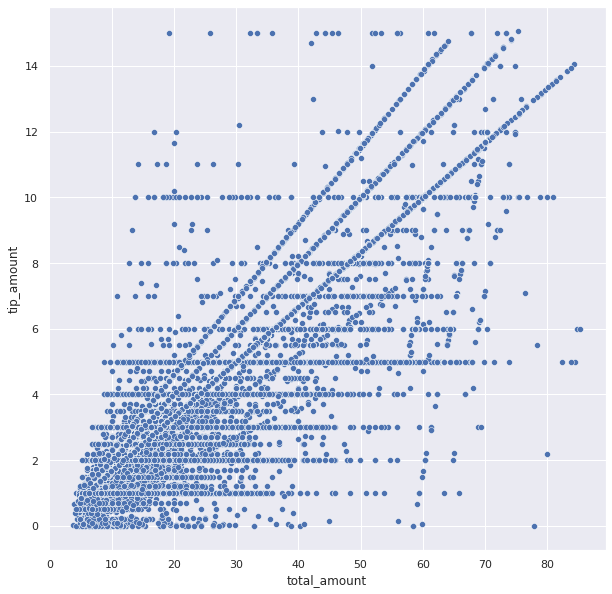

In [ ]:
sns.scatterplot(data = df_2, x = df_2['total_amount'],y =  df_2['tip_amount'])

In [ ]:
df = df.astype({'month':'string'})

In [ ]:
season_dict = {'1':'Winter',
               '2': 'Winter',
               '3': 'Spring', 
               '4': 'Spring',
               '5': 'Spring',
               '6': 'Summer',
               '7': 'Summer',
               '8': 'Summer',
               '9': 'Fall',
               '10': 'Fall',
               '11': 'Fall',
               '12': 'Winter'}


In [ ]:
df['season'] = df['month'].apply(lambda x: season_dict[x])

In [ ]:
df_count_trip_season = pd.DataFrame(df.groupby(['season'])['pick_datetime'].count().reset_index())
df_count_trip_season.rename(columns= {"pick_datetime":"trip_count"}, inplace = True)
df_count_trip_season = df_count_trip_season.sort_values(by = 'trip_count', ascending = False)


df_mean_tip_season = pd.DataFrame(df.groupby(['season'])['tip_by_min'].mean().reset_index())
df_mean_tip_season = df_mean_tip_season.sort_values(by = 'tip_by_min', ascending = False)

Text(0.5, 1.0, 'Tip by minute by Season')

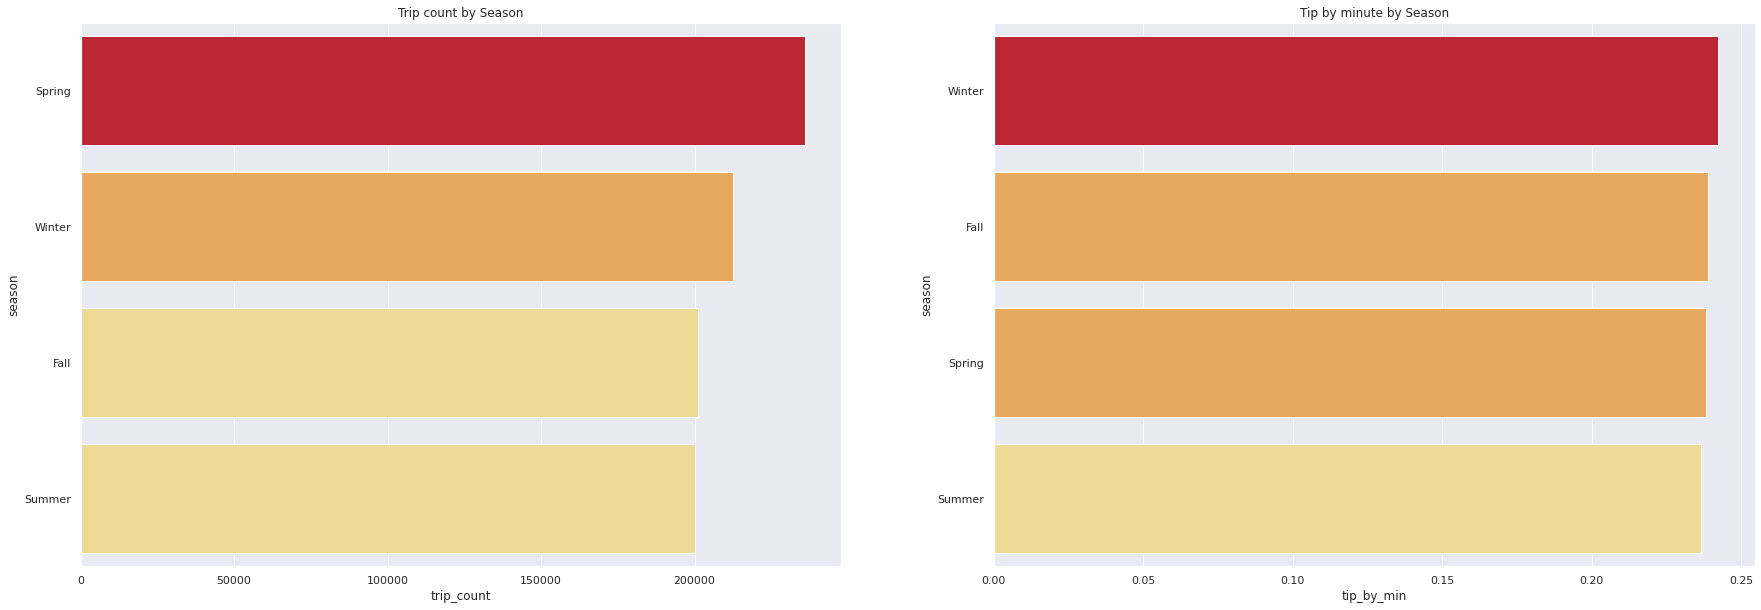

In [ ]:
sns.set(rc={'figure.figsize':(30,10)})
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.barplot(data=df_count_trip_season, y="season", x="trip_count", ax = ax1,orient = 'h', palette=colors_from_values(df_count_trip_season.trip_count, "YlOrRd"))
sns.barplot(data=df_mean_tip_season, y="season", x="tip_by_min", ax = ax2, orient = 'h', palette=colors_from_values(df_mean_tip_season.tip_by_min, "YlOrRd"))

ax1.set_title('Trip count by Season')
ax2.set_title('Tip by minute by Season')

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive/UDESA/MCD01/Archivos Practica

/content/gdrive/MyDrive/UDESA/MCD01/Archivos Practica


In [ ]:
df_median_income = pd.read_csv('Median income nyc 2016.csv', sep = ';')
df_median_income

,Location,Household Type,TimeFrame,DataFormat,Data,Fips
0,Astoria,All Households,2016,Dollars,67043,401
1,Battery Park,All Households,2016,Dollars,152286,101
2,Bay Ridge,All Households,2016,Dollars,73884,310
3,Bayside,All Households,2016,Dollars,87807,411
4,Bedford Park,All Households,2016,Dollars,37803,207
...,...,...,...,...,...,...
57,Upper West Side,All Households,2016,Dollars,123496,107
58,Washington Heights,All Households,2016,Dollars,57748,112
59,Williamsbridge/Olinville,All Households,2016,Dollars,57026,212
60,Williamsburg (North Side),All Households,2016,Dollars,77347,301


In [ ]:
df_grouped = df.groupby(['zone_pick', 'borough_pick'])['tip_by_min'].mean().reset_index()

In [ ]:
df_grouped = df_grouped.merge(df_median_income[["Location","Data"]], how="left", left_on="zone_pick", right_on="Location",suffixes=[None,"_drop"]).drop("Location",axis=1)

In [ ]:
df_grouped.dropna(inplace = True)
df_grouped = df_grouped[(df_grouped['zone_pick'] != 'Bay Ridge') & (df_grouped['zone_pick'] != 'Canarsie') & (df_grouped['zone_pick'] != 'Ridgewood')]

<ipython-input-168-69081490bac9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grouped.dropna(inplace = True)


<Axes: xlabel='Data', ylabel='tip_by_min'>

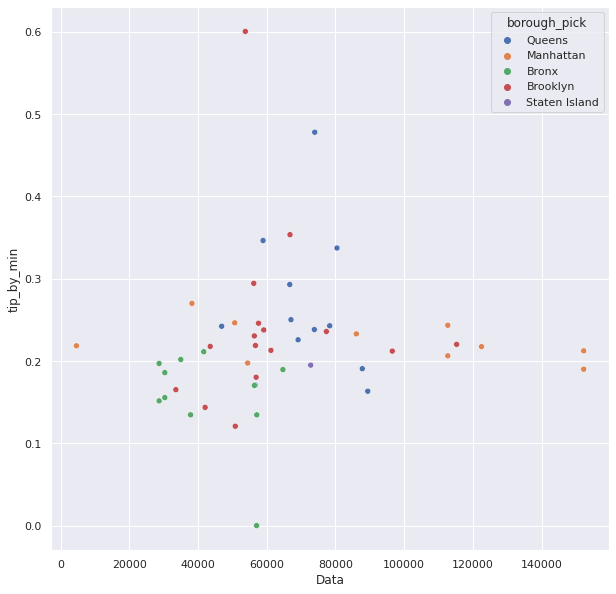

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(data = df_grouped, x = df_grouped['Data'],y =  df_grouped['tip_by_min'],  hue = 'borough_pick')